### Approach

In order to predict shared bike demand following approach has been taken.

1. Import modules, Read dataset

2. Working with Categorical Data
 - Encoding
 - Univariate and Bivariate Analysis, Visualization
 - Dropping columns (if applicable)
 
3. Working with Numeric Data
 - Checking statistical summary
 - Univariate and Bivariate Analysis, Visualization
 - Outlier Detection
 - dropping columns (if applicable)
 
4. Split train-test and Scaling

5. Feature selection and Building Model
  - Extract top n features with RFE
  - Improvise the model further inspecting adjusted R-squared, VIF and p-vales
  - Build final model
  - validate linear regression assumptions, residuals

6. Predicting target variable using final model

7. Model evaluation
  - R2 square
  - RMSE/MSE

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importing Modules

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')

### Reading the dataset

In [3]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/day.csv")
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  casual      731 non-null    int64  
 14  registered  731 non-null    int64  
 15  cnt         731 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB


**Comment**

- The dataset does not have any missing value, has 731 rows and 16 columns.
- 'instant' is a unique identifier column, hence setting this as index
- Year, Month and Date can be extracted from 'dteday'. After that 'dteday', 'mnth', 'yr' columns can be dropped.
- Categorical features like 'season', 'weathersit' and 'weekday' have numeric value like 1,2,3... 
  We will encode them for better readability and suitable for regression model.
- Categorical features ('holiday', 'workingday') are already labeled as 0 and 1 - do not need further encoding
- Numeric columns are : temp, atemp, hum, windspeed, casual, registered, cnt - will be analyzed separately

In [5]:
df.set_index('instant', inplace=True)
df.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,
1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [6]:
df["date"] = pd.DatetimeIndex(df["dteday"]).day
df["month"] = pd.DatetimeIndex(df["dteday"]).month_name()
df["year"] = pd.DatetimeIndex(df["dteday"]).year

# dropping the redundant columns
df.drop(["dteday","mnth"], axis=1, inplace=True)

# checking the new dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 731 entries, 1 to 731
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      731 non-null    int64  
 1   yr          731 non-null    int64  
 2   holiday     731 non-null    int64  
 3   weekday     731 non-null    int64  
 4   workingday  731 non-null    int64  
 5   weathersit  731 non-null    int64  
 6   temp        731 non-null    float64
 7   atemp       731 non-null    float64
 8   hum         731 non-null    float64
 9   windspeed   731 non-null    float64
 10  casual      731 non-null    int64  
 11  registered  731 non-null    int64  
 12  cnt         731 non-null    int64  
 13  date        731 non-null    int64  
 14  month       731 non-null    object 
 15  year        731 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 97.1+ KB


In [7]:
df.groupby("weekday").sum()["workingday"]

weekday
0      0
1     90
2    103
3    103
4    102
5    102
6      0
Name: workingday, dtype: int64

**Comment:**
- This means Sunday is encoded as 0 and Saturday is encoded as 6

In [8]:
# season, weathersit, weekday

name_dict = {"season" : {1:"spring", 2:"summer", 3:"fall", 4:"winter"}, 
             "weathersit" : {1: "Clear/Partly Cloudy", 2: "Mist and Cloudy", 3: "Light Snow/Rain", 4: "Heavy Snow/Rain"},
             "weekday" : {0: "Sunday", 1:"Monday", 2:"Tuesday", 3:"Wednesday", 4:"Thursday", 5:"Friday", 6:"Saturday"}}

for column in name_dict.keys():
    df[column] = df[column].apply(lambda x : name_dict[column][x])

df.head()

,season,yr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,date,month,year
instant,,,,,,,,,,,,,,,,
1,spring,0,0,Saturday,0,Mist and Cloudy,0.344167,0.363625,0.805833,0.160446,331,654,985,1,January,2011
2,spring,0,0,Sunday,0,Mist and Cloudy,0.363478,0.353739,0.696087,0.248539,131,670,801,2,January,2011
3,spring,0,0,Monday,1,Clear/Partly Cloudy,0.196364,0.189405,0.437273,0.248309,120,1229,1349,3,January,2011
4,spring,0,0,Tuesday,1,Clear/Partly Cloudy,0.200000,0.212122,0.590435,0.160296,108,1454,1562,4,January,2011
5,spring,0,0,Wednesday,1,Clear/Partly Cloudy,0.226957,0.229270,0.436957,0.186900,82,1518,1600,5,January,2011


### Visualizing Categorical Data

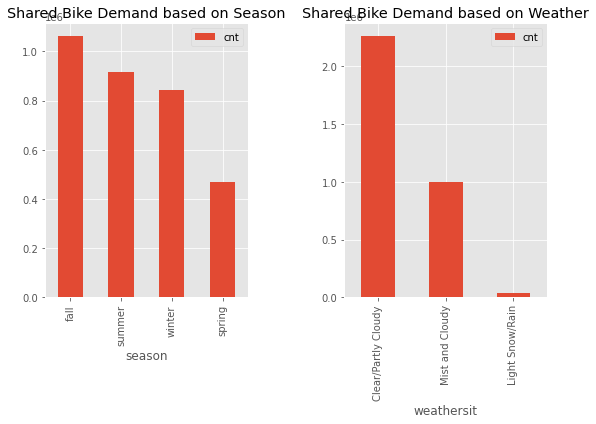

In [9]:
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(1, 3, 1, title="Shared Bike Demand based on Season")
ax2 = fig.add_subplot(1, 3, 2, title="Shared Bike Demand based on Weather")

df.groupby('season').sum().sort_values('cnt', ascending=False)[['cnt']].plot.bar(ax=ax1)
df.groupby('weathersit').sum().sort_values('cnt', ascending=False)[['cnt']].plot.bar(ax=ax2)

plt.tight_layout()
plt.show()

**Comment:**
- People are most likely to rent shared bikes in fall and least likely to rent shared bikes in spring
- Highest demand of shared bikes is seen in Clear/Partly Cloudy weather
- Light Snow/Rain results in very low bike demand and there is no bike demand in Heavy Snow/Rain

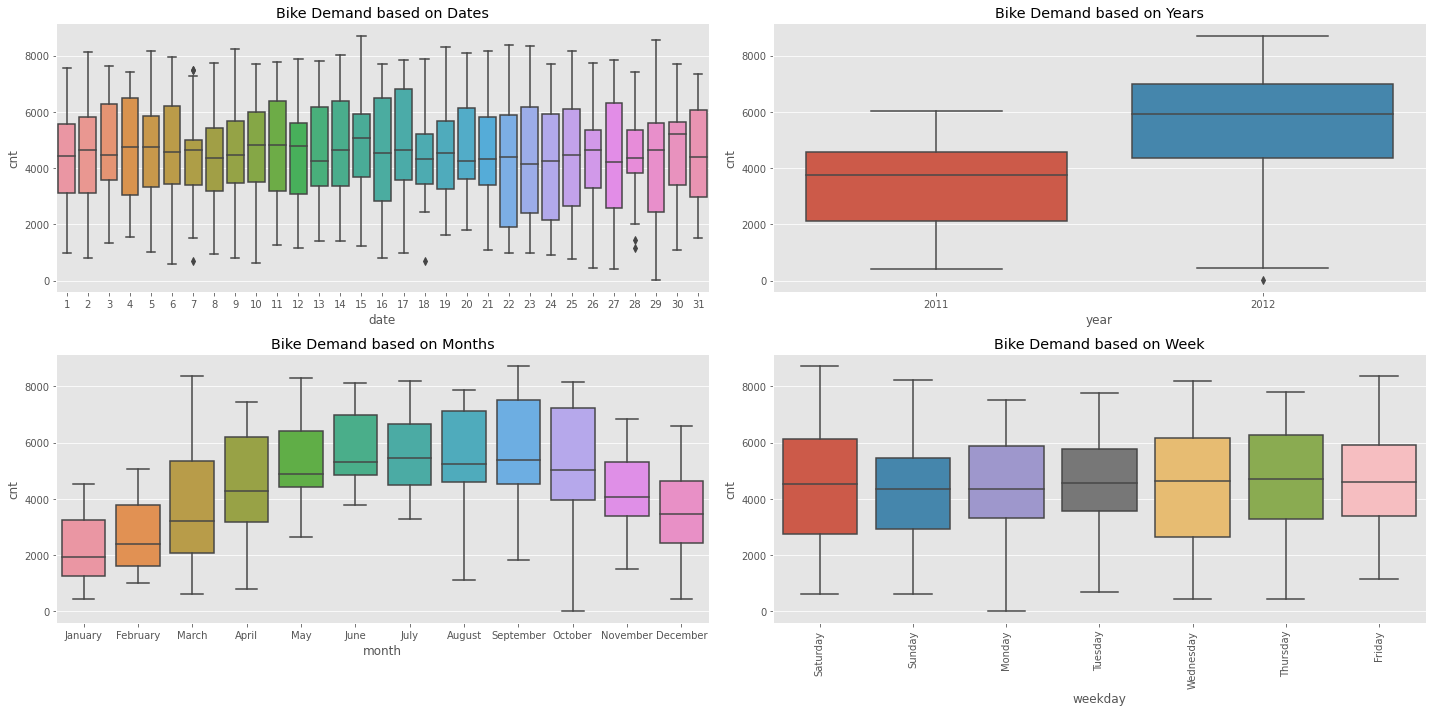

In [10]:
fig = plt.figure(figsize=(20,10))

ax1 = fig.add_subplot(2, 2, 1, title="Bike Demand based on Dates")
ax2 = fig.add_subplot(2, 2, 2, title="Bike Demand based on Years")
ax3 = fig.add_subplot(2, 2, 3, title="Bike Demand based on Months")
ax4 = fig.add_subplot(2, 2, 4, title="Bike Demand based on Week")

sns.boxplot(df['date'], df['cnt'], ax=ax1)
sns.boxplot(df['year'], df['cnt'], ax=ax2)
sns.boxplot(df['month'], df['cnt'], ax=ax3)
sns.boxplot(df['weekday'], df['cnt'], ax=ax4)

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

**Comment:**
- Dates between 5-8 have shown comparatively higher demand. This might be because of other underlying factors for e.g. holidays.
- Demand of share bikes increased a lot in 2019 from previous year.
- November, December, January, February months have comparative less demands than other months.
- Highest number of bike rent in a day is higher on Satuday, Sunday than weekdays

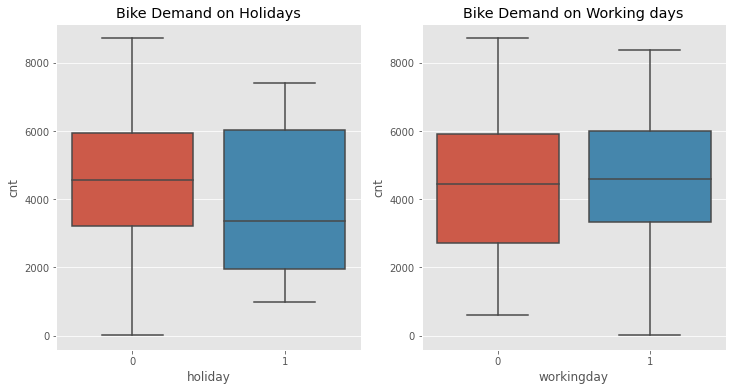

In [11]:
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(1, 2, 1, title="Bike Demand on Holidays")
ax2 = fig.add_subplot(1, 2, 2, title="Bike Demand on Working days")

sns.boxplot(df['holiday'], df['cnt'], ax=ax1)
sns.boxplot(df['workingday'], df['cnt'], ax=ax2)

plt.show()

**Comment**
- Bike demand is very similar whether its working day or not, working day has slightly less demand
- The lowest number of bike rents is higher on holidays than that of non-holidays
- The highest number of bike rents is higher on non-holidays than that of holidays

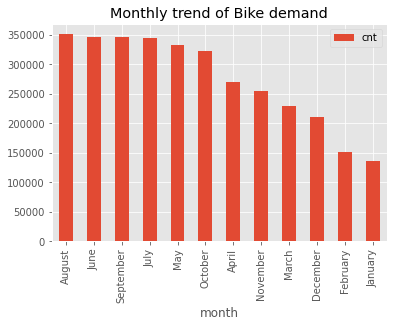

In [12]:
df.groupby('month').sum().sort_values('cnt', ascending=False)[['cnt']].plot.bar()
plt.title("Monthly trend of Bike demand")
plt.show()

### Encoding the categorical Variables

Month shows very strong trend for bike demands.
Dividing the months into 4 groups based of bike demand trend seen above.

- group1 [July, August, Sepetember] column name : jul_aug_sep (Highest bike demand)
- group2 [May, Jun, Oct] column name : may_jun_oct
- group3 [March, April, November] column name: mar_apr_nov
- group4 [December, February, January] (Lowest bike demand)
For the last group, no columns will be required as 0 in the first 3 groups would signify it.

In [13]:
df["jul_aug_sep"] = df["month"].apply(lambda month : 1 if month in ["July","August","September"] else 0)
df["may_jun_oct"] = df["month"].apply(lambda month : 1 if month in ["May","June","October"] else 0)
df["mar_apr_nov"] = df["month"].apply(lambda month : 1 if month in ["March","April","November"] else 0)

In [14]:
# dropping 'month', 'year' columns as it is redundant now
df.drop(['month'], axis=1, inplace=True)
df.drop(['year'], axis=1, inplace=True)

In [15]:
def add_dummies(df, feature):
    dummy_df = pd.get_dummies(df[feature], drop_first='True')
    df.drop(feature, axis=1, inplace=True)
    print(df.columns)
    return pd.concat([df,dummy_df], axis=1)

df = add_dummies(df,'season')
df = add_dummies(df,'weekday')
df = add_dummies(df,'weathersit')

Index(['yr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp',
       'hum', 'windspeed', 'casual', 'registered', 'cnt', 'date',
       'jul_aug_sep', 'may_jun_oct', 'mar_apr_nov'],
      dtype='object')
Index(['yr', 'holiday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum',
       'windspeed', 'casual', 'registered', 'cnt', 'date', 'jul_aug_sep',
       'may_jun_oct', 'mar_apr_nov', 'spring', 'summer', 'winter'],
      dtype='object')
Index(['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt', 'date', 'jul_aug_sep', 'may_jun_oct',
       'mar_apr_nov', 'spring', 'summer', 'winter', 'Monday', 'Saturday',
       'Sunday', 'Thursday', 'Tuesday', 'Wednesday'],
      dtype='object')


### Visualizing Numeric Data

In [16]:
df_num_var = df[["temp", "atemp", "hum", "windspeed", "casual", "registered", "cnt"]]

<Figure size 432x288 with 0 Axes>

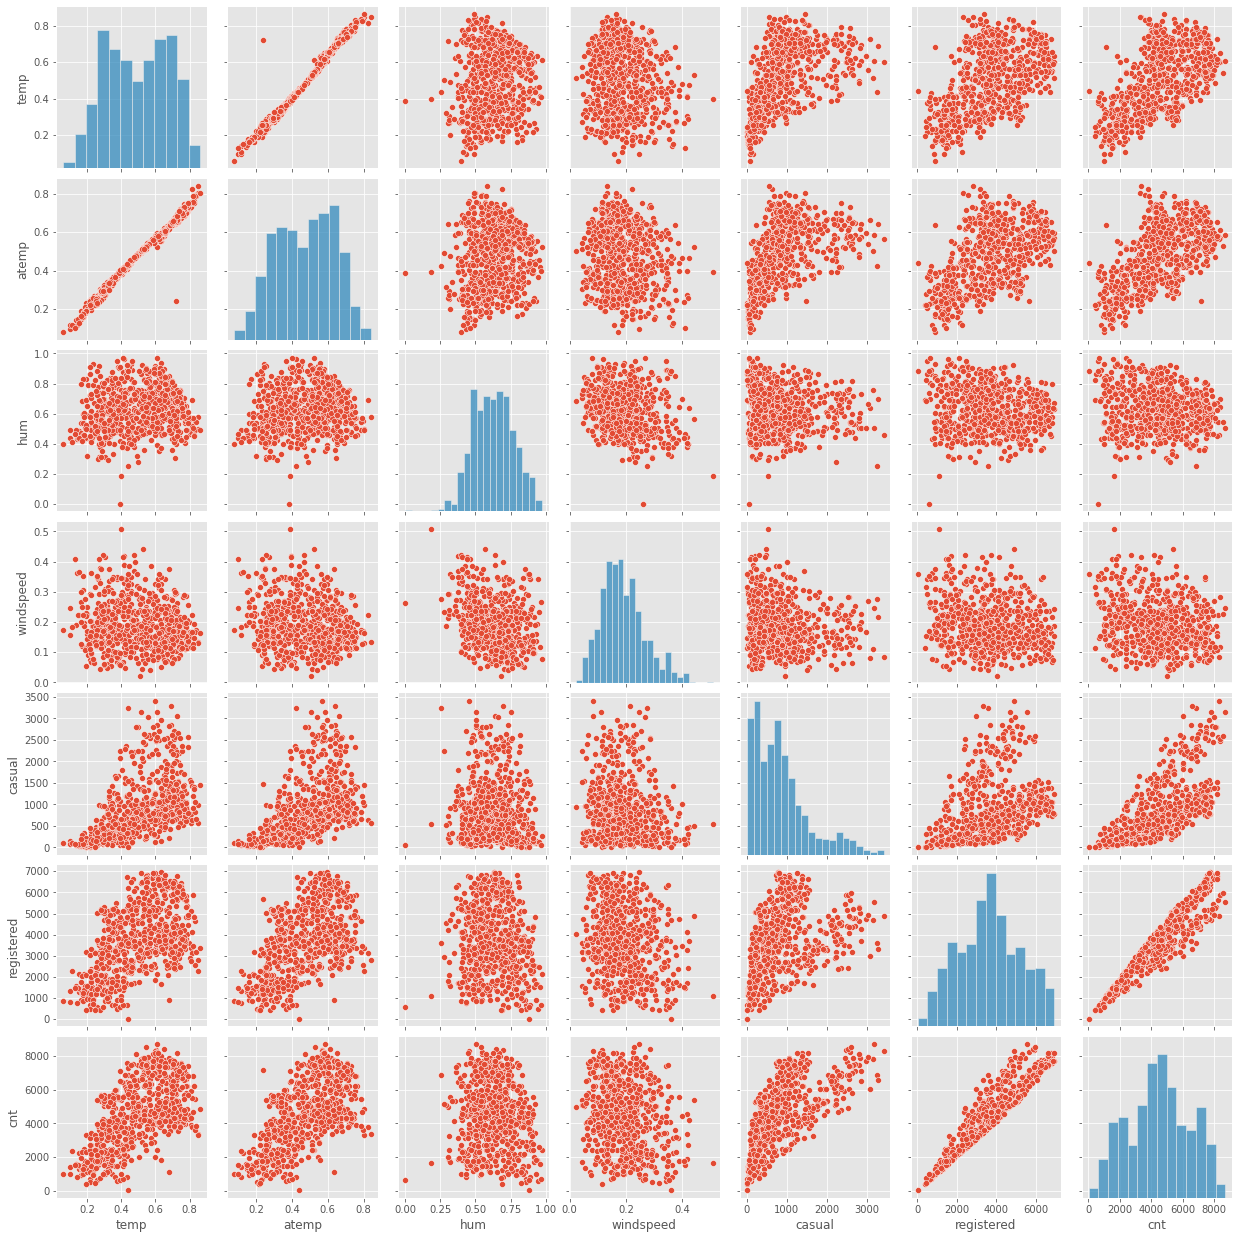

In [17]:
plt.figure()
sns.pairplot(df_num_var)
plt.show()

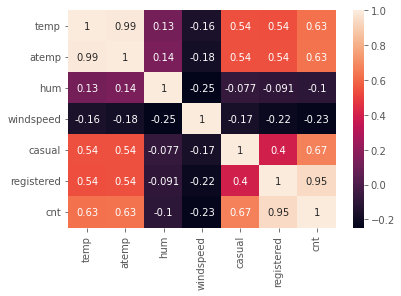

In [18]:
plt.figure()
sns.heatmap(df_num_var.corr(), annot=True)
plt.show()

**Comment**
- temp and atemp have very high linear relationship (as seen in the pairplot), their correlation coefficient as high as 0.99
- cnt, registered columns look linearly related too

In [19]:
df[~(df['casual'] + df['registered'] == df['cnt'])]

,yr,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,cnt,date,jul_aug_sep,may_jun_oct,mar_apr_nov,spring,summer,winter,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Light Snow/Rain,Mist and Cloudy
instant,,,,,,,,,,,,,,,,,,,,,,,,,


**Comment**
- 'cnt' is our target variable and we see that casual + registered = cnt
- Hence, casual and registered are dependant variables and can be dropped

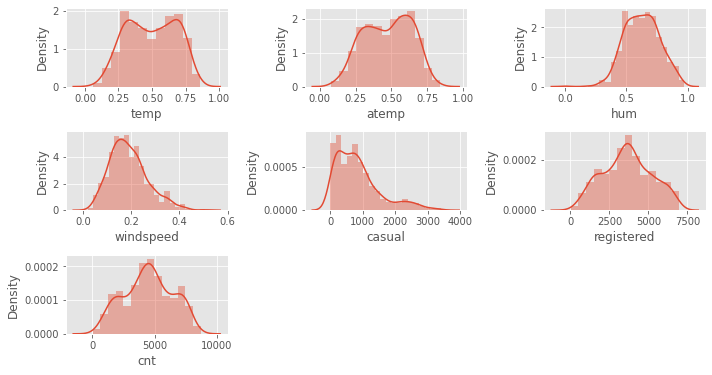

In [20]:
fig=plt.subplots(figsize=(10, 10))

for i, j in enumerate(["temp", "atemp", "hum", "windspeed", "casual", "registered", "cnt"]):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace = 1.0)
    sns.distplot(df[j])
    plt.tight_layout()

**Comment**
- temp and atemp have similar distribution
- Humidity is most likely to be between 50-75 units
- Windspeed is most commonly seen between 8-12 units
- registered and cnt have similar distribution, as majority of the bikes are rented by registered customers

### Outlier Detection for Numeric Variables

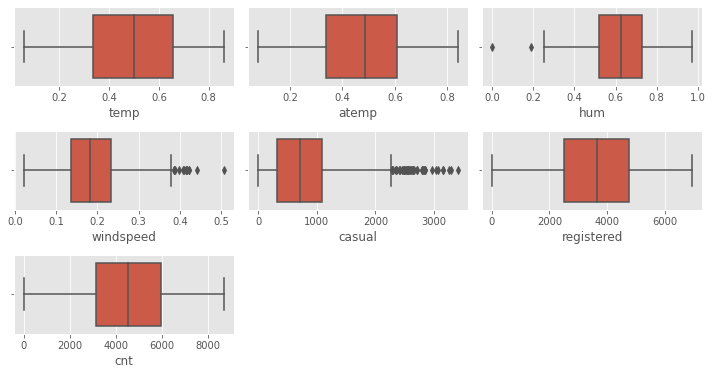

In [21]:
fig=plt.subplots(figsize=(10, 10))

for i, j in enumerate(["temp", "atemp", "hum", "windspeed", "casual", "registered", "cnt"]):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace = 1.0)
    sns.boxplot(df[j])
    plt.tight_layout()

**Comment**
- For 'windspeed' and 'casual', we can see some outliers.
- 'windspeed' is a predictor and 'casual' is directly related to 'cnt' as casual + registered = cnt
- We will consider 99 percentile for both of this

In [22]:
df = df[~((df.windspeed > np.nanpercentile(df.windspeed, 99)) | (df.casual > np.nanpercentile(df['casual'], 99)))]
print(df.shape)

(715, 25)


### Splitting the data and Scaling

In [23]:
# Since cnt = casual + register, casual and register cannot be counted as predictors to prevent data leakage
X = df.drop(['cnt', 'casual', 'registered'], axis=1)
y = df[['cnt']]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [24]:
num_vars = ['temp', 'atemp', 'hum', 'windspeed']
X[num_vars].describe()

,temp,atemp,hum,windspeed
count,715.000000,715.000000,715.000000,715.000000
mean,0.495684,0.474711,0.630827,0.187898
std,0.183650,0.163261,0.140804,0.073538
min,0.059130,0.079070,0.000000,0.022392
25%,0.336250,0.337510,0.524583,0.134646
50%,0.498333,0.486733,0.630833,0.179721
75%,0.656250,0.610803,0.732708,0.231185
max,0.861667,0.840896,0.972500,0.407346


We will scale the only numeric features, excluding categorical features encoded with 0 and 1

In [25]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train[num_vars] = scaler.fit_transform(X_train[num_vars])
X_test[num_vars] = scaler.transform(X_test[num_vars])

# Building Model

In [26]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [27]:
def calculate_vif(X_train):
    vif_df = pd.DataFrame()
    vif_df['Features'] = X_train.columns
    vif_df['Variance Inflation Factor'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
    vif_df['Variance Inflation Factor'] = round(vif_df['Variance Inflation Factor'], 2)
    vif_df = vif_df.sort_values(by = 'Variance Inflation Factor', ascending = False)
    print(vif_df)

In [28]:
# Regressor 1 : This is the model including all features

X_train_lm = sm.add_constant(X_train)
regressor1 = sm.OLS(y_train, X_train_lm).fit()
print(regressor1.summary())
print("=======================================================================================================")
calculate_vif(X_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     116.5
Date:                Tue, 15 Feb 2022   Prob (F-statistic):          7.41e-173
Time:                        04:31:21   Log-Likelihood:                -4039.9
No. Observations:                 500   AIC:                             8124.
Df Residuals:                     478   BIC:                             8217.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1899.7847    299.811     

**Comment:**

- High f-statistic value confirm the linear regressor model is a significant one.

In [33]:
# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

def top_n_features(n):
    top_n_feat = []
    
    lm = LinearRegression()
    lm.fit(X_train_lm, y_train)
    rfe = RFE(lm, n_features_to_select=n)
    rfe = rfe.fit(X_train_lm, y_train)
    
    print("Top %d features selected by RFE" %n)
    ranking = list(zip(X_train_lm.columns,rfe.support_,rfe.ranking_))
    
    for i in ranking:
        if i[1]:
            top_n_feat.append(i[0])
    print(top_n_feat)
    return top_n_feat

In [34]:
top_10_feat = top_n_features(10)
top_12_feat = top_n_features(12)
top_15_feat = top_n_features(15)

Top 10 features selected by RFE
['yr', 'holiday', 'temp', 'hum', 'windspeed', 'spring', 'summer', 'winter', 'Light Snow/Rain', 'Mist and Cloudy']
Top 12 features selected by RFE
['yr', 'holiday', 'temp', 'atemp', 'hum', 'windspeed', 'jul_aug_sep', 'spring', 'summer', 'winter', 'Light Snow/Rain', 'Mist and Cloudy']
Top 15 features selected by RFE
['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed', 'jul_aug_sep', 'may_jun_oct', 'mar_apr_nov', 'spring', 'summer', 'winter', 'Light Snow/Rain', 'Mist and Cloudy']


**Comment:** We would check the adjusted R-squared value of the linear regressor model by taking 10, 12, 15 features respectively

In [35]:
def build_regressor(X_train,y_train,cols):
    X_train_new = X_train[cols]
    X_train_lm = sm.add_constant(X_train_new)
    regressor = sm.OLS(y_train, X_train_lm).fit()
    print(regressor.summary())
    print("=======================================================================================================")
    calculate_vif(X_train_lm)

In [36]:
build_regressor(X_train,y_train,top_10_feat)
print("\n\n")
build_regressor(X_train,y_train,top_12_feat)
print("\n\n")
build_regressor(X_train,y_train,top_15_feat)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     226.5
Date:                Tue, 15 Feb 2022   Prob (F-statistic):          1.99e-176
Time:                        04:40:15   Log-Likelihood:                -4060.6
No. Observations:                 500   AIC:                             8143.
Df Residuals:                     489   BIC:                             8190.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            2780.6298    347.759     

**Comment:**
- With top 15 features given by RFE, the model resulted in adjusted R-squared of 0.819
- Both top 10 and top 12 features on the other hand produced adjusted R-squared lower than that
- We will now manually inspect the p-values and VIF for the model built with top 15 features and try to improvise it. 
 

In [37]:
# Removing Saturday

top_14 = ['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'spring', 'summer', 'winter', 'Monday', 'Saturday', 'Tuesday', 'Light Snow/Rain', 'Mist and Cloudy']

build_regressor(X_train,y_train,top_14)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     164.3
Date:                Tue, 15 Feb 2022   Prob (F-statistic):          8.00e-174
Time:                        04:40:28   Log-Likelihood:                -4055.8
No. Observations:                 500   AIC:                             8142.
Df Residuals:                     485   BIC:                             8205.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            2508.0485    357.236     

**Comment:**
- Removing Sunday did not impact adjusted R-sqaured
- We will remove 'Saturday' (Highest p-value in the latest model)

In [38]:
top_13 = ['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'spring', 'summer', 'winter', 'Monday',  'Light Snow/Rain','Tuesday', 'Mist and Cloudy']

build_regressor(X_train,y_train,top_13)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     175.4
Date:                Tue, 15 Feb 2022   Prob (F-statistic):          4.84e-174
Time:                        04:40:46   Log-Likelihood:                -4058.0
No. Observations:                 500   AIC:                             8144.
Df Residuals:                     486   BIC:                             8203.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            2642.7571    352.368     

**Comment:**
- Removing 'Sunday','Saturday' did not impact adjusted R-squared
- We will remove 'workingday' (Highest p-value in the latest model)

In [39]:
top_12 = ['yr', 'holiday', 'temp', 'hum', 'windspeed', 'spring', 'summer', 'winter', 'Monday',  'Light Snow/Rain','Tuesday', 'Mist and Cloudy']

build_regressor(X_train,y_train,top_12)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     188.3
Date:                Tue, 15 Feb 2022   Prob (F-statistic):          3.50e-174
Time:                        04:40:54   Log-Likelihood:                -4060.4
No. Observations:                 500   AIC:                             8147.
Df Residuals:                     487   BIC:                             8202.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            2771.2824    348.634     

**Comment:**

- Removing 'Sunday','Saturday','workingday' from top 15 features of RFE did not impact adjusted R-squared of model 
- All the features have VIF < 7 now, which ensures there is no collinearity.
- All the features have p-value < 0.05 (assumed significance level), hence all the features are important.
- Hence we would build our final model with the following features
top_12 = ['yr', 'holiday', 'temp', 'hum', 'windspeed', 'spring', 'summer', 'winter', 'Monday',  'Light Snow/Rain','Tuesday', 'Mist and Cloudy']


### Final Model

In [40]:
top_12 = ['yr', 'holiday', 'temp', 'hum', 'windspeed', 'spring', 'summer', 'winter', 'Monday',  'Light Snow/Rain','Tuesday', 'Mist and Cloudy']
X_train_top12 = X_train[top_12]
regressor = LinearRegression()
regressor.fit(X_train_top12, y_train)

LinearRegression()

### Residual Analysis of Training Data

Text(0.5, 0, 'Errors')

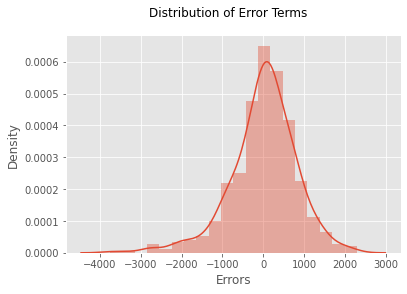

In [41]:
y_train_pred = regressor.predict(X_train_top12)

# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_pred), bins = 20)
fig.suptitle('Distribution of Error Terms')
plt.xlabel('Errors')

**Comment:**
Error terms are normally distributed around 0. Hence assumption of linear regression holds true here.

### Making Predictions Using the Final Model

In [42]:
X_test_top12 = X_test[top_12]

y_test_pred = regressor.predict(X_test_top12)

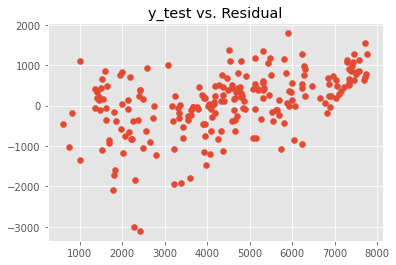

In [43]:
plt.scatter(y_test, (y_test-y_test_pred))
plt.title("y_test vs. Residual")
plt.show()

**Comment:**
- There is no visible pattern in residual with change in y_test. Hence we can assume residual having constant variance/homoscedastic. 

### Model Evaluation

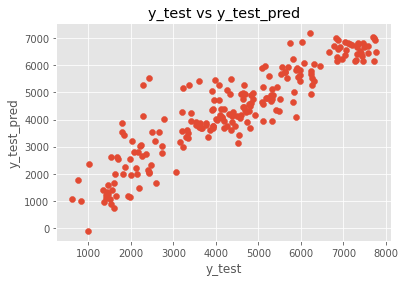

In [44]:
# Plotting y_test and y_pred to understand the spread

plt.scatter(y_test, y_test_pred)
plt.title('y_test vs y_test_pred')
plt.xlabel('y_test')
plt.ylabel('y_test_pred')      
plt.show()

### MAE, MSE, RMSE

In [45]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, y_test_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_test_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

MAE: 590.2462531788929
MSE: 603993.125027546
RMSE: 777.169946039826


### R2_score

In [46]:
from sklearn.metrics import r2_score
print(r2_score(y_test, y_test_pred))

0.8297421178033049


### Subjective Question Code

In [ ]:
# Top 3 features with respect to absolute value of coefficient- temp, Light Snow/Rain, year

#(1)temp             3681.2173
#(2) yr              1982.9860
#(3)Light Snow/Rain -1976.9925

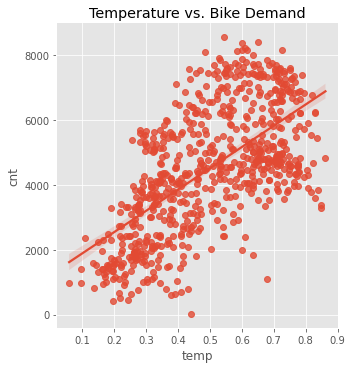

In [47]:
sns.lmplot(x="temp",y="cnt",data=df)
plt.title("Temperature vs. Bike Demand")
plt.show()

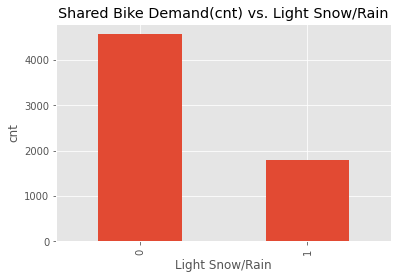

In [48]:
df.groupby("Light Snow/Rain").mean()["cnt"].plot.bar()
plt.ylabel("cnt")
plt.title("Shared Bike Demand(cnt) vs. Light Snow/Rain")
plt.show()

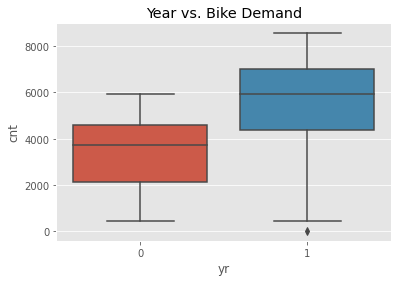

In [49]:
sns.boxplot(df['yr'], df['cnt'])
plt.title("Year vs. Bike Demand")
plt.show()

### Conclusion:

The expression for Multiple Linear Regression is-

y = a + b1X1 + b2X2 + ... + bnXn

Here, a is the intercept.

b1, b2, ... , bn are the coefficients of the independent variables. bn is the change in y(cnt, here) with unit change in Xn, when rest of the variables are constant.

With respect to the final model,

- number of predictors n = 12

- The independent variables that were used in final model are-
'yr', 'holiday', 'temp', 'hum', 'windspeed', 'spring', 'summer', 'winter', 'Monday',  'Light Snow/Rain','Tuesday', 'Mist and Cloudy'

- Among this 3 most important features were - temp, Light Snow/Rain, year
This was decided by inspecting absolute value of their coefficient. Negative sign is coefficient means the variable is negative correlated with target varible (cnt).

- The model is also validated against serveral assumptions of Linear Regression - linearity, normally distributed error, contant variance of error.

- The model is evaluated by R2_score and RMSE.
R2_score of 0.8372 means 83.72% of variance in the data is explained by the model.
RMSE or Root Mean Squarred Error is calculated in the same unit as the target variable. RMSE of 780 means, the prediction made by this model can be over or underestimated by 780 units at maximum.

